# Computational model
The current version of the simulator emulates a stochastic distributed (by agent / individual) model (actually not really -- *n* {0,1}-draws with probability *p* are deterministically represented as p.n draws of 1 & exactly (1-p).n draws of 0) using aggregates.
In other words it should be more computationally efficient than a purely distributed model.
However, in the current form, only individuals that have exactly the same behavior (contact and response to infection) are aggregated.
As an example, one can easily model different counties and different categories of people (age), one cannot model non-hierachical heterogeneity associated to the handling of contacts at schools, household, work, etc. 
Future version will enable such complex modeling.
In a very near future, instead of computing a number of infected people (per day; per aggregate), a probability distribution will be output instead.

# Some illustrative examples

## Example 1: calibrate
This very first example exposes together on the same plot the result of a simulation and the actual reported cases (used for calibration) for France. 

env: SEEPIAPATH=data
env: PYTHONPATH=src


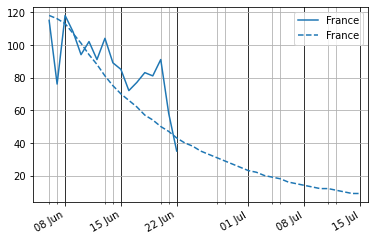

In [1]:
%env SEEPIAPATH=data
%env PYTHONPATH=src
%run src/parse_seepia --event=hospitalisations --memi='sandbox/5Jun.memi' --start='{5 Jun}' --trace=sandbox/example-orig.trace --window='{5 Jun},{22 Jun}' --all 
%run src/simu --input=sandbox/5Jun.memi --trace=sandbox/example-simu.trace -t 40 --all --param=N:0.74
%run src/plot --stat=infected --trace=sandbox/example-orig.trace,sandbox/example-simu.trace 

In the repository, scripts are stored in *src/* directory, and data (extracted from SEEPIA project that itself extracts reported cases from Santé Publique France) in *data/* directory.

**src/parse_seepia** creates `sandbox/5Jun.memi` file that describes the model (a default one that here uses the incidence data from hospitalisations on June 5).
It also creates `sandbox/example-orig.trace` file that traces hospitalisations for the time period that goes from June 5 to June 22, that can be used for plotting.

**src/simu** creates from the simulation, trace file `sandbox/example-simu.trace`, providing a forecast (40 days from June 5). `N` is a parameter of our simple model that represents $R(t)/S(t)$ where $R(t)$ represents the effective reproduction number and $S(t)$ the proportion of susceptibles in the population at time $t$. 
A good value for `N` (here $0.74$) can be obtained using calibration as explained below.

**src/plot** plots the two corresponding traces. Observe that here that incidence data of reported hospitalisation are oversimplistically confused with infections.

In [18]:
%run src/tuner --config=example/R-5Jun.search --test-limit 500

env: SEEPIAPATH=data
env: PYTHONPATH=src


[  4562s]    INFO opentuner.search.plugin.DisplayPlugin: tests=292, best {'__N__': 0.7412112089247299}, cost time=1.6556, found by RandomNelderMead
[  4569s]    INFO opentuner.search.metatechniques: AUCBanditMetaTechniqueA: [('NormalGreedyMutation', 159), ('DifferentialEvolutionAlt', 152), ('UniformGreedyMutation', 149), ('RandomNelderMead', 41)]
[  4569s]    INFO opentuner.search.plugin.DisplayPlugin: tests=504, best {'__N__': 0.7412112089247299}, cost time=1.6556, found by RandomNelderMead


Autotuning done!
score = 1.6556016597510372 | config = {'__N__': 0.7414549177418485}


Calibration is performed using autotuning.

**src/tuner** autotunes the parameter `N` by comparing the output of the simulator with a reference trace. 
The score $\|1-R^2\|=1.65$ here shows the relativelly poor quality of the fit. 

## Example 2: Effective Reproduction Number / Distanciation Factor
The effective reproduction number $R(t)$ is supposed to reflect the growth factor of the epidemic at time $t$.
In our simple model, $N(t)$ reflects the transmission rate which is a function of social disctancing:
If the entire population is susceptible ($S(t)=1$ in the text above) then $N(t)=R(t)$.
While $R(t)$ shall decrease if the number of immuned people increases, $N(t)$ only depends contact rate.
We shall call it the distanciation factor: if $N(t)<1$ then the epidemic shall decrease; If the epidemic decreases, it does not mean that necessarily $N(t)<1$. 
$N(t)$ is a parameter of our model. It actually does not have to be homogeneous among the entire population. 
Plotting its value with time is an interesting metric that can be obtained using our calibration mechanism.

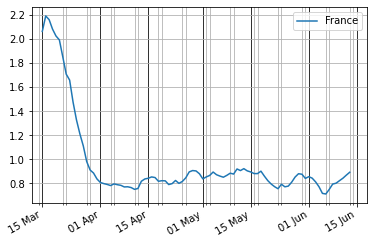

In [2]:
%run src/proximity_plotting --timewindow='{15 March},{20 June}' --sliding=7 --limit=200 --output=sandbox/R.trace --noplot
%run src/plot --trace=sandbox/R.trace --stat=N 

**src/proximity_plotting** creates a trace of $N(t)$ using reported data from March 15 till June 20.
Because those data are quite noisy, $N(t)$ is actually obtained by calibrating (with an upper-bound in the number of run of 200 per calibration) the simulator during time interval $[t,t+7[$.

## Example 3: Simple plotting
Obviously, the toolbox can be used to plot various data including the reported cases in France.

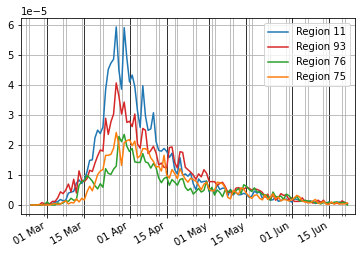

In [10]:
%run src/parse_seepia --trace=sandbox/full.trace --event=hospitalisations
%run src/plot --trace=sandbox/full.trace --groups=R76,R75,R93,R11 --normalize --stat=infected

**src/parse_seepia** parses the csv file from SEEPIA project and generates a full trace here of hospitalisations for each region of France.
**src/plot** selects only regions named *R75, R76, R93*, and *R11* and plots the infected cases per habitant (option --normalize).

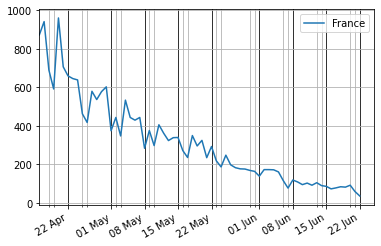

In [5]:
%run src/parse_seepia --trace=sandbox/recent.trace --window='{15 April}' --event=hospitalisations
%run src/plot --trace=sandbox/recent.trace --aggregate

**src/seepia** can specify a window for the trace in different ways. If the end is not specified (as for here), it covers the interval till today.
If not already aggregated in the trace, **src/plot** can aggregate the groups (instead of plotting all the regions here).

# The model
To be completed...

# The different modules. API.
The tool is made up of five important parts.
1. The simulator (**src/simu**) takes a input file (in yaml format) that describes each group of the population and the way it interacts (contacts) with other groups. It outputs a trace.
2. This means that such a description yaml file must be generated. **src/parse_seepia.py** does so based on data extracted from data.gouv.fr (provided by Sante Publique France). The dynamic of contacts, infectiousness, and contagiousness which are parameters of the model are fixed values in the yaml file (set up as arguments of parse_seepia.py here).
3. The calibration of the simulator shall use an autotuner (**src/tuner.py** is a wrapper to Open-tuner) that needs a metric:
4. **src/error.py** shall take two traces (the observed values and the simulated values) and evaluate the quality of the simulation.
5. **src/plot.py** takes a trace to generate some plots.

In addition, **src/proximity_plotting** plots the proximity parameter found by the autotuner over a sliding windows of dates.

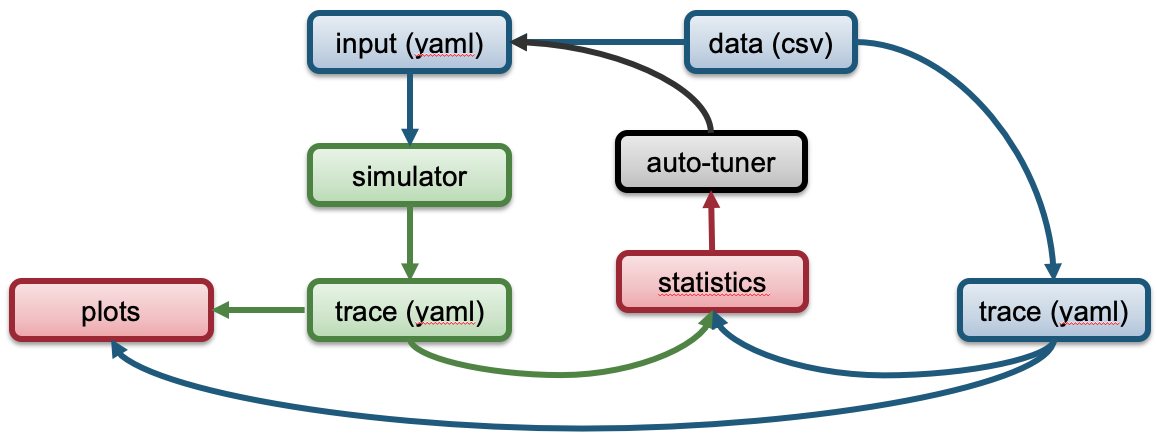

In [17]:
from IPython.display import display, Image
display(Image(filename='doc/description.png'))

## Input format for the simulator
The input file uses yaml format (called memi). 
It is made of three "sections": groups, contacts and states.
Following is an example that describes two groups (respectively R75 et R76).
For each group: size corresponds to the number of people; alias is an alias name that can be used further; contagiousity is the level of contagiousity (serial interval) of an infected individual as a function of time (here a Weibull distribution is used).
The contacts defines a *contact matrix* between groups. Here we assumed no contacts between people of different regions (lockdown).
The states is the fraction of susceptible (at the current time) and infected individuals (during the last 9 time stamps). 
The time window of size 9 is here arbitrary and fixed in hard for now and corresponds to the size of the serial interval that is used.

Observe that the yaml format allows extensions: 
1.  fields can be added without hurting the parsing;
2.  also yaml anchors (&W and *W in the following example) can be used;
3.  finally expressions (`parameters['N'] / groups['R75']['size']` in the following example) can be used.

Yaml anchors should **not** be confused with parameters: a parameter (here N in the following example) will be replaced everywhere in the yaml (preprocessing phase).
For now parameters are restricted to simple scalar variables (shall be arrays in a near future).
The reason for this distinction is that parameter values as specified in the yaml (memi) input file can be overriden by the simulator itself as explained below.

While the idea of the tool is to allow the description of any "complex" models through the memi API, as mentioned above, **src/parse_seepia** can generate simple memi files. 

In [1]:
%run src/parse_seepia --help

Usage: src/parse_seepia.py 
	[-h|--help] dumps this help and exists
	[-i|--csv= file] input csv file
	[-r|--region= region1,region2,...] restricts to those regions
	[-a|--all] merge regions
	[-N N] fixes parameter N
	[--Wshape k] fixes shape parameter of Weibull distribution used for contagiosity (default 5.42)
	[--Wscale lambda] fixes scale parameter of Weibull distribution used for contagiosity (default 2.24)
	[-e|--event= actes|urgences|hospitalisations] uses this event (default is hospitalisations)
	[-l|--list-regions] list regions
	[--memi= file] creates memi file for simulator
	[-s|--start t|date] + timestamp for memi file. Default is t=-1
	[-t|--trace= file] creates trace file
	[-w|--window t[,dt]] trace window {i in t<i<=t+dt<=-1}. Default is {i s.t. i<=-1}. If dt is ommited {i s.t t<i<=-1}. /!\ -1=today; -2==yesterday... /!\


In [6]:
%run src/parse_seepia --memi=sandbox/example.memi --event=hospitalisations --start='{5 Jun}' --region=R75,R76 --all -N 0.7
%cat sandbox/example.memi

env: SEEPIAPATH=data
env: PYTHONPATH=src
contacts:
  R75 from R75: parameters['N'] / groups['R75']['size']
  R76 from R76: parameters['N'] / groups['R76']['size']
groups:
  R75:
    contagiousity: _W
    long name: Region 75
    size: 5911482
  R76:
    contagiousity: _W
    long name: Region 76
    size: 5774185
metadata:
  date: '2020-06-05T00:00:00'
  phase: hospitalisations
  t: -18
parameters:
  N: '0.7'
  Wscale: 5.42
  Wshape: 2.24
states:
  R75:
    infected:
    - 2.029947820191282e-06
    - 2.706597093588376e-06
    - 1.353298546794188e-06
    - 1.8607855018420084e-06
    - 1.691623183492735e-06
    - 1.353298546794188e-06
    - 1.691623183492735e-06
    - 2.368272456889829e-06
    - 3.2140840486361963e-06
    - 2.706597093588376e-06
    susceptible: 0.9999999998733174
  R76:
    infected:
    - 2.770953822920464e-06
    - 2.770953822920464e-06
    - 2.944138436852993e-06
    - 1.905030753257819e-06
    - 3.6368768925831092e-06
    - 3.117323050785522e-06
    - 2.078215367190

In [3]:
%run src/parse_seepia --trace=sandbox/example-orig.trace --event=hospitalisations --window='{5 Jun},9' --region=R75,R76 --all -N 0.7
%cat sandbox/example-orig.trace

rename:
  all: France
start: '2020-06-06T00:00:00'
trace:
- all:
    infected: 15
    size: 11685667
    susceptible: 11677489
- all:
    infected: 13
    size: 11685667
    susceptible: 11677476
- all:
    infected: 11
    size: 11685667
    susceptible: 11677465
- all:
    infected: 14
    size: 11685667
    susceptible: 11677451
- all:
    infected: 15
    size: 11685667
    susceptible: 11677436
- all:
    infected: 7
    size: 11685667
    susceptible: 11677429
- all:
    infected: 6
    size: 11685667
    susceptible: 11677423
- all:
    infected: 12
    size: 11685667
    susceptible: 11677411
- all:
    infected: 6
    size: 11685667
    susceptible: 11677405


In [4]:
%run src/simu --help
%run src/error --help

Usage: src/simu.py 
	[-h|--help] dumps this help and exists
	[-i|--input= file] input file (default STDIN)
	[-o|--trace= file]
	[-p|--plot] plots
	[-t t] + number of timestamps for the simulator. Default is 50
Usage: src/error.py 
	[-h|--help] dumps this help and exists
	[-t|--traces= file_orig,file_simu]
	[-a|--aggregate]
	[-s|--stat= infected|immuned|log-infected|log-immuned|ratio-infected]
	[-g|--groups= group1,group2,...] restricts to those groups


In [5]:
%run src/parse_seepia --memi=sandbox/example.memi --start='{5 Jun}' --trace=sandbox/example-orig.trace --window='{5 Jun},9' --event=hospitalisations  --all 
%run src/simu --input=sandbox/example.memi --trace=sandbox/example-simu.trace -t 9 --all --param=N:0.9
%run src/error --trace=sandbox/example-orig.trace,sandbox/example-simu.trace --stat=infected

8.094744121715076


In [6]:
%run src/simu --input=sandbox/example.memi --trace=sandbox/example-simu.trace -t 9 --all --param=N:0.8
%run src/error --trace=sandbox/example-orig.trace,sandbox/example-simu.trace --stat=infected

2.3423236514522823


In [7]:
%run src/tuner --help

usage: tuner.py [-h] [--machine-class MACHINE_CLASS] [--parallel-compile] [--test-limit TEST_LIMIT]
                [--stop-after STOP_AFTER] [--parallelism PARALLELISM] [--pipelining PIPELINING]
                [--bail-threshold BAIL_THRESHOLD] [--no-dups] [--seed-configuration FILENAME]
                [--results-log RESULTS_LOG] [--results-log-details RESULTS_LOG_DETAILS] [--quiet]
                [--display-frequency DISPLAY_FREQUENCY] [--technique TECHNIQUE] [--list-techniques]
                [--generate-bandit-technique] [--label LABEL] [--print-search-space-size] [--database DATABASE]
                [--print-params] [--config FILENAME]

optional arguments:
  -h, --help            show this help message and exit
  --machine-class MACHINE_CLASS
                        name of the machine class being run on
  --parallel-compile    present if compiling can be done in parallel
  --test-limit TEST_LIMIT
                        stop tuning after given tests count
  --stop-after STOP_

In [8]:
%cat example/R-5Jun.search
%run src/tuner --config=example/R-5Jun.search --test-limit 500

init :
 - parse_seepia : {
  memi : 5Jun.memi,
  event : hospitalisations,
  s : '{5 Jun}',
  N : 0.7,
  trace : 6Jun-14Jun-orig.trace,
  window : '{5 Jun},9',
  all: True }

run:
  - simu : {
    input : 5Jun.memi,
    trace : temp_tuner_simu.trace,
    param : 'N:__N__',
    t : 9,
    all : True }

  - error : {
    traces : '6Jun-14Jun-orig.trace,temp_tuner_simu.trace',
    stat : infected,
    aggregate : True }

search_parameters:
  - __N__ : {lb: 0.5, ub: 3.0}  

create_file: False

[    17s]    INFO opentuner.search.plugin.DisplayPlugin: tests=296, best {'__N__': 0.7410097133343685}, cost time=1.6556, found by RandomNelderMead
[    23s]    INFO opentuner.search.metatechniques: AUCBanditMetaTechniqueA: [('NormalGreedyMutation', 166), ('UniformGreedyMutation', 155), ('DifferentialEvolutionAlt', 150), ('RandomNelderMead', 30)]
[    24s]    INFO opentuner.search.plugin.DisplayPlugin: tests=504, best {'__N__': 0.7410097133343685}, cost time=1.6556, found by RandomNelderMead


Autotuning done!
score = 1.6556016597510372 | config = {'__N__': 0.741310986553946}


Usage: src/plot.py 
	[-h|--help] dumps this help and exists
	[-t|--trace= file[,file]]
	[-a|--aggregate]
	[-n|--normalize]
	[-s|--stat= infected|immuned|susceptible]
	[-g|--groups= group1,group2,...] restricts to those groups
	[-o|--output= figname] exports plot


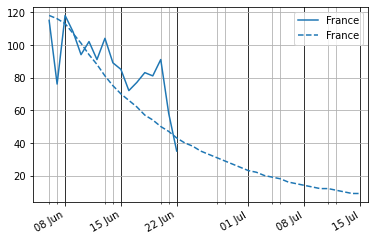

In [9]:
%run src/plot --help
%run src/parse_seepia --trace=sandbox/example-orig.trace --event=hospitalisations --window='{5 Jun}' --all 
%run src/simu --input=sandbox/example.memi --trace=sandbox/example-simu.trace -t 40 --all --param=N:0.74
%run src/plot --stat=infected --trace=sandbox/example-orig.trace,sandbox/example-simu.trace 

In [12]:
%run src/tuner --test-limit 200 --config _temp_conf_proximity.search


[    35s]    INFO opentuner.search.plugin.DisplayPlugin: tests=204, best {'__N__': 1.6570968471302465}, cost time=2.7147, found by RandomNelderMead


Autotuning done!
score = 2.7147079018138123 | config = {'__N__': 1.657081842144767}


Usage: src/proximity_plotting.py 
	[-h|--help] dumps this help and exists
	[-t|--timewindow=start,width] defines the set of available time iteration
	[-s|--sliding=s] fixes the size of the sliding windows iterating on the timewindow
	[-l|--limit=l] fixes the maximum number of test done for an iteration of the autotuner
	[-o|--output=filename] saves the values of N found in the specified filename
	[-n|--noplot] do not plot the result at the end
	[-v|--verbose] verbose mode


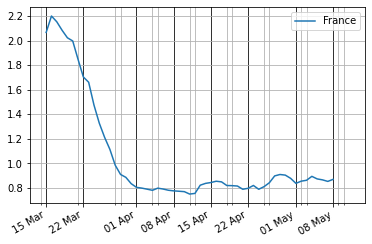

In [16]:
%run src/proximity_plotting --help
%run src/proximity_plotting --timewindow='{15 March},{20 June}' --sliding=7 --limit=200 --output=sandbox/R.trace --noplot
%run src/plot --trace=sandbox/R.trace --stat=N 